<a href="https://colab.research.google.com/github/Aditya-k07/BERT_tweets/blob/main/bert_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
       UserName  ScreenName         Location     TweetAt  \
31089     34888       79840            Lagos  06-04-2020   
35564     39363       84315              NaN  09-04-2020   
144        3943       48895              NaN  16-03-2020   
8202      12001       56953  irlande du nord  19-03-2020   
31720     35519       80471   Zaria, Nigeria  07-04-2020   

                                           OriginalTweet           Sentiment  
31089   Without the there would not be any problem wh...             Neutral  
35564  Rice &amp; wheat prices surge amid fears Covid...  Extremely Negative  
144    When the government says to start social dista...            Positive  
8202   What the shops are doing is obeying the law of...            Positive  
31720  Kaduna State Task Force on Covid 19 led by the...            Negative  


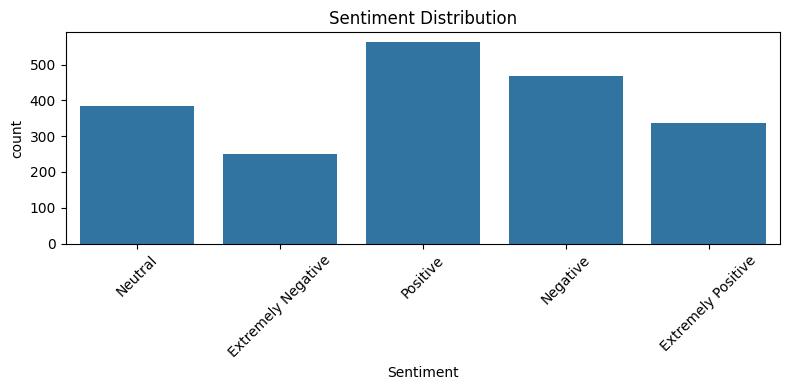

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report

train_df = pd.read_csv("Corona_NLP_train.csv", encoding='latin-1', on_bad_lines='skip')
test_df = pd.read_csv("Corona_NLP_test.csv", encoding='latin-1', on_bad_lines='skip')


train_df = train_df.sample(2000, random_state=42)
test_df = test_df.sample(500, random_state=42)


print(train_df.columns)
print(train_df.head())

plt.figure(figsize=(8, 4))
sns.countplot(x='Sentiment', data=train_df)
plt.title("Sentiment Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text


train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

train_df['CleanTweet'] = train_df['OriginalTweet'].apply(clean_text)
test_df['CleanTweet'] = test_df['OriginalTweet'].apply(clean_text)

train_df['Sentiment'] = train_df['Sentiment'].replace({
    "Extremely Negative": "Negative",
    "Extremely Positive": "Positive"
})
test_df['Sentiment'] = test_df['Sentiment'].replace({
    "Extremely Negative": "Negative",
    "Extremely Positive": "Positive"
})


label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
train_df['Label'] = train_df['Sentiment'].map(label_map)
test_df['Label'] = test_df['Sentiment'].map(label_map)


train_df = train_df[['CleanTweet', 'Label']]
test_df = test_df[['CleanTweet', 'Label']]

In [4]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)


def tokenize(example):
    return tokenizer(example['CleanTweet'], padding='max_length', truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize)
test_ds = test_ds.map(tokenize)


train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [5]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [12]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.config.problem_type = "single_label_classification"
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=1,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


def cast_labels(example):
    example["labels"] = int(example["labels"])
    return example

train_dataset = train_dataset.map(cast_labels)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.877700,0.716713
2,0.522500,0.749199
3,0.311700,0.730388


TrainOutput(global_step=375, training_loss=0.5735280685424805, metrics={'train_runtime': 148.1839, 'train_samples_per_second': 40.49, 'train_steps_per_second': 2.531, 'total_flos': 394670126592000.0, 'train_loss': 0.5735280685424805, 'epoch': 3.0})

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Corona_NLP_train.csv", encoding='latin-1')

df.columns = df.columns.str.strip()

df['TweetAt'] = pd.to_datetime(df['TweetAt'], errors='coerce')

df['Sentiment'] = df['Sentiment'].replace({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
})

df = df[df['Sentiment'].isin(['Positive', 'Neutral', 'Negative'])]

df = df.dropna(subset=['TweetAt'])

df['Month'] = df['TweetAt'].dt.to_period('M').astype(str)


<ipython-input-13-ea7ecbe679af>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'], errors='coerce')


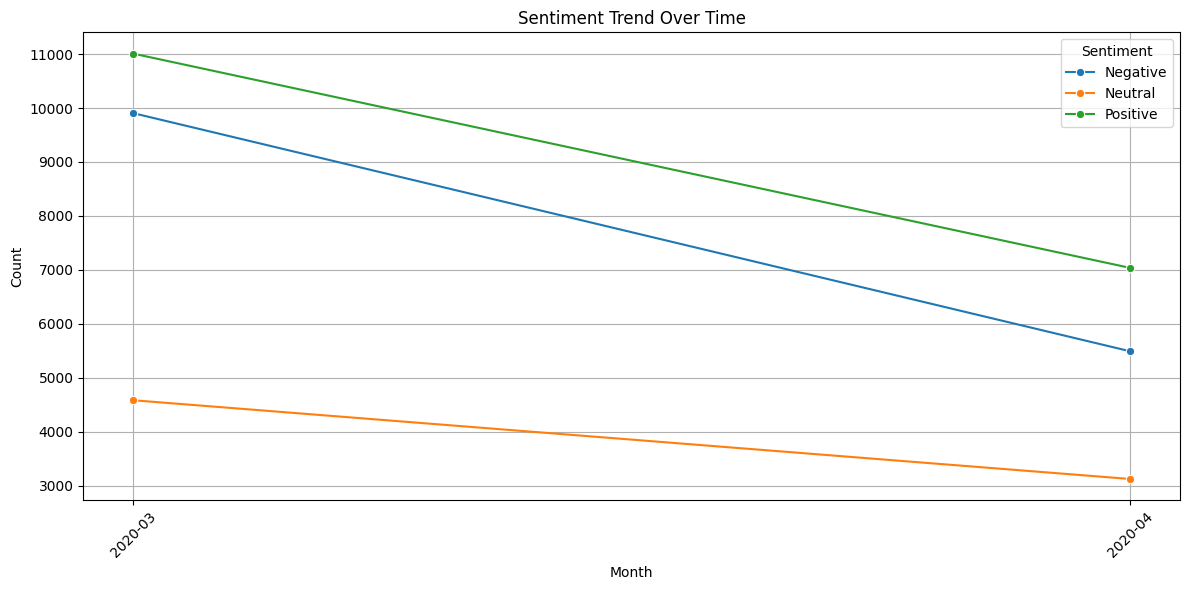

In [14]:
monthly_trend = df.groupby(['Month', 'Sentiment']).size().reset_index(name='Count')

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_trend, x='Month', y='Count', hue='Sentiment', marker='o')
plt.title("Sentiment Trend Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


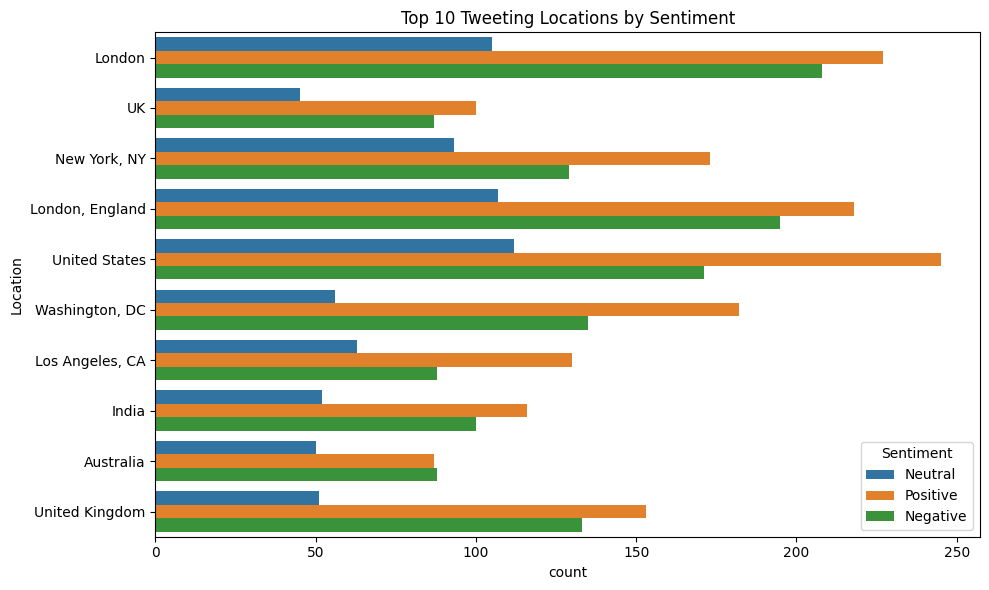

In [15]:
top_locations = df['Location'].value_counts().head(10).index.tolist()
location_df = df[df['Location'].isin(top_locations)]

plt.figure(figsize=(10,6))
sns.countplot(data=location_df, y='Location', hue='Sentiment')
plt.title("Top 10 Tweeting Locations by Sentiment")
plt.tight_layout()
plt.show()


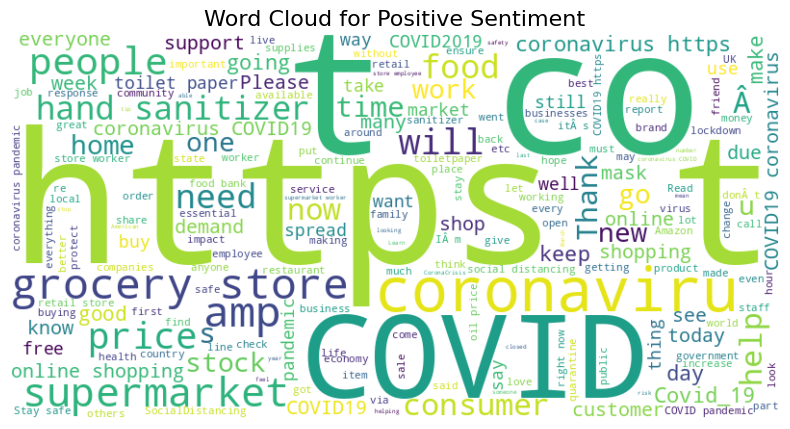

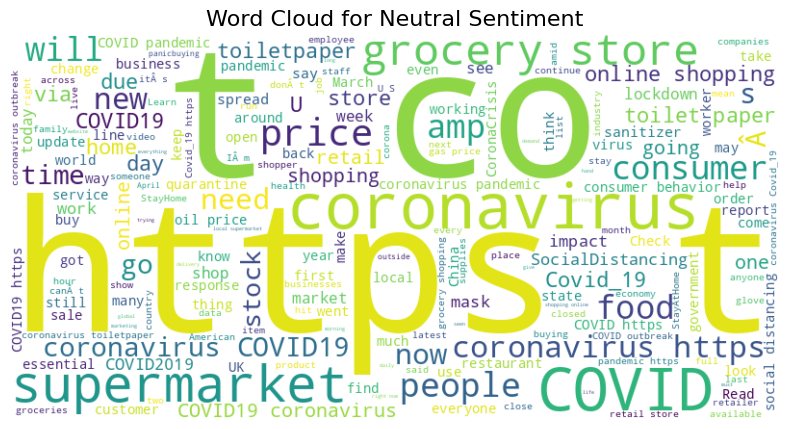

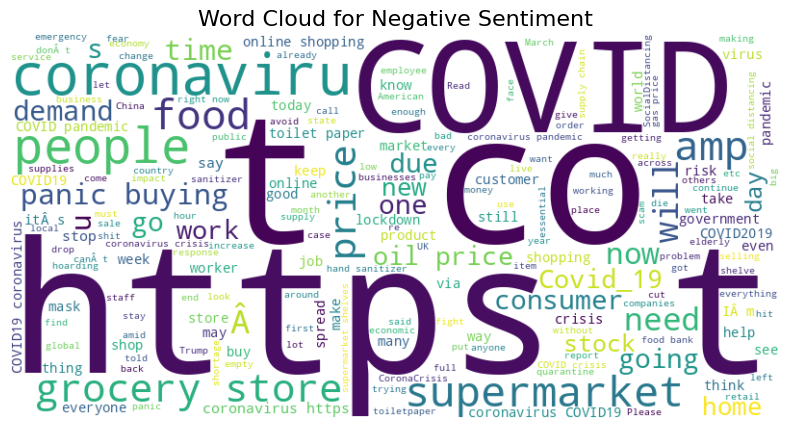

In [16]:
from wordcloud import WordCloud

def show_wordcloud(sentiment):
    text = " ".join(df[df['Sentiment'] == sentiment]['OriginalTweet'].dropna())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment} Sentiment", fontsize=16)
    plt.show()

for sentiment in ['Positive', 'Neutral', 'Negative']:
    show_wordcloud(sentiment)


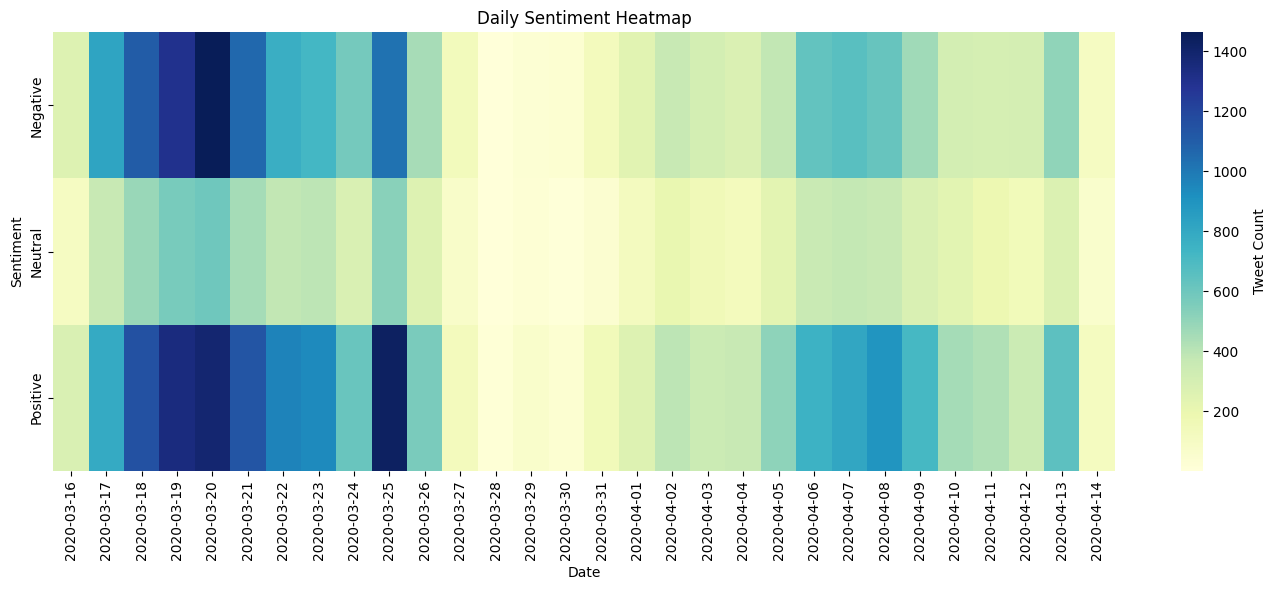

In [17]:
df['Date'] = df['TweetAt'].dt.date
daily_sentiment = df.groupby(['Date', 'Sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(daily_sentiment.T, cmap='YlGnBu', cbar_kws={'label': 'Tweet Count'})
plt.title("Daily Sentiment Heatmap")
plt.ylabel("Sentiment")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [18]:
import torch
print(torch.cuda.is_available())


True
